In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.random import normal
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
allowed_chars = 52
max_len = 450

def get_noize():
    return tf.random.normal(shape=(52,64,1))


def one_hot(smi):
    smi = "`" * (max_len - len(smi)) + smi
    encoded = [[0]*allowed_chars for _ in range(max_len)]
    for i, c in enumerate(smi):
        encoded[i][chars[c]] = 1
    return tf.transpose(tf.constant(encoded))

    
real_data = []
chars = set("`")
with open("smiles.smi") as f:
    for smiles in f:
        real_data.append(smiles[:-1])
        chars.update(smiles[:-1])
chars = sorted(chars)
chars = {c: i for i,c in enumerate(chars)}

real_data = [one_hot(smi) for smi in real_data]


In [3]:
def layer_bidir(units=40):
    fw = layers.GRU(units=units, return_sequences=True, go_backwards=False)
    bw = layers.GRU(units=units, return_sequences=True, go_backwards=True)
    bidir = layers.Bidirectional(layer=fw, backward_layer=bw)
    return bidir

def make_generator(dict_size=52, max_smi_len=450, lstm_units=40):
    model = Sequential()
    model.add(layers.Dense(40))
    model.add(layer_bidir(lstm_units))
    model.add(layers.Dense(1))
    model.add(layers.Flatten())
    model.add(layers.Dense(450, activation="softmax"))  
    return model

def make_discriminator():
    model = Sequential()
    model.add(layers.Input(shape=(52,450)))
    model.add(layers.Dense(40))
    model.add(layers.Dense(1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

cross_entropy = BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [8]:
generator = make_generator()
generator.build(input_shape=(52,64, 1))
generator.summary(80)                

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_6 (Dense)                    (52, 64, 40)                    80          
                                                                                
 bidirectional_1 (Bidirectional)    (52, 64, 80)                    19680       
                                                                                
 dense_7 (Dense)                    (52, 64, 1)                     81          
                                                                                
 flatten_2 (Flatten)                (52, 64)                        0           
                                                                                
 dense_8 (Dense)                    (52, 450)                       29250       
                                                                                
Total 

In [9]:
discriminator = make_discriminator()
discriminator.build()
discriminator.summary(80)

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_9 (Dense)                    (None, 52, 40)                  18040       
                                                                                
 dense_10 (Dense)                   (None, 52, 1)                   41          
                                                                                
 flatten_3 (Flatten)                (None, 52)                      0           
                                                                                
 dense_11 (Dense)                   (None, 1)                       53          
                                                                                
Total params: 18,134
Trainable params: 18,134
Non-trainable params: 0
________________________________________________________________________________


In [10]:
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

Glosses = []
Dlosses = []

batch_size = 32

print("Starting Training Loop...")

num_epochs = 50
for epoch in range(num_epochs):
    print(f"epoch {epoch+1}/{num_epochs}")
    Glosses.append([])
    Dlosses.append([])
    
    for i in range(len(real_data) // batch_size):
        
        noize = get_noize()
        data = tf.concat([real_data[i:i+batch_size]], 0)[0]
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_data = generator(noize, training=True)
            
            fake_data = tf.expand_dims(fake_data, 0)
            data = tf.expand_dims(data, 0)
            fake_output = discriminator(fake_data, training=True)
            real_output = discriminator(data, training=True)
            
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
            Glosses[-1].append(gen_loss)
            Dlosses[-1].append(disc_loss)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        print(f"  step {i}/{len(real_data)//batch_size}", end="; ")
        print(f"Dloss {Dlosses[-1][-1]}, Gloss {Glosses[-1][-1]}", end="\r")
    print(f"  step {i}/{len(real_data)//batch_size}", end="; ")
    print(f"Dloss {Dlosses[-1][-1]}, Gloss {Glosses[-1][-1]}")

        

Starting Training Loop...
epoch 1/50
  step 142/143; Dloss 1.3644418716430664, Gloss 0.6640033125877383
epoch 2/50
  step 142/143; Dloss 1.1579447984695435, Gloss 0.6771004796028137
epoch 3/50
  step 142/143; Dloss 1.0195499658584595, Gloss 0.6866781115531921
epoch 4/50
  step 142/143; Dloss 0.9262133836746216, Gloss 0.6942467093467712
epoch 5/50
  step 142/143; Dloss 0.8614941835403442, Gloss 0.7009795904159546
epoch 6/50
  step 142/143; Dloss 0.8138229846954346, Gloss 0.7086893916130066
epoch 7/50
  step 142/143; Dloss 0.7759843468666077, Gloss 0.7185254096984863
epoch 8/50
  step 142/143; Dloss 0.7410979270935059, Gloss 0.7338538169860843
epoch 9/50
  step 142/143; Dloss 0.7063720226287842, Gloss 0.7552484273910522
epoch 10/50
  step 142/143; Dloss 0.6708837151527405, Gloss 0.7826699018478394
epoch 11/50
  step 142/143; Dloss 0.7773153781890869, Gloss 0.6610217094421387
epoch 12/50
  step 142/143; Dloss 0.752058744430542, Gloss 0.67807096242904669
epoch 13/50
  step 142/143; Dloss 0

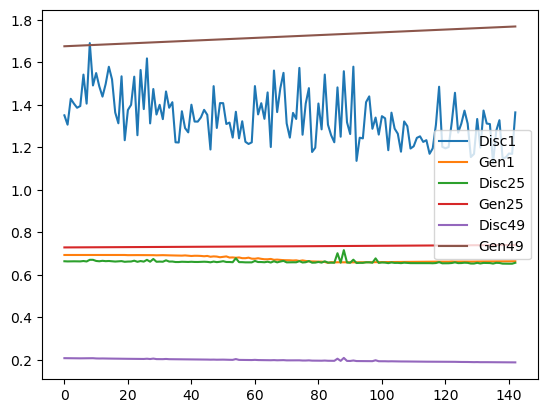

In [21]:
from matplotlib import pyplot as plt
import numpy as np

Dlosses = np.array(Dlosses)
Glosses = np.array(Glosses)

for i in range(0, num_epochs, 24):
    plt.plot(Dlosses[i], label=f"Disc{i+1}")
    plt.plot(Glosses[i], label=f"Gen{i+1}")
    
plt.legend()
plt.savefig("graph1.png")

In [14]:
chars_reversed = {v:k for k,v in chars.items()}

def interpret_generated(generator_out):
    smi = ''
    out = np.array(generator_out).T
    for i in out:
        smi += chars_reversed[np.argmax(i)]
    return smi
    
    

In [15]:
noize = get_noize()
out = generator(noize, training=False)

interpret_generated(out)

'FFFbFFFFFFFbbFFFbFFFFFFFFbFFFFFFFFbFFFFFFFFFFnFbFFFMFFFFFFFFFbFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFMMFFFbFFFFFFFFFFFbFFFFFFFFFFFFFbFFFFFFFFMFFFFbFFFFFFFFnFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbbFFFFbFFFFFFFFMFFFFFFFFFFbFFFFFFFFFFbFFFFFFFFFFFFFbbFbMFbFFFFbFFFFFFFFFFFFFFFbFFFFFFbFFFFFFFFFFFFFFFFFFFFFFFFFFFFbbFFFFFFFFFFFFFFFFFFFFMFbFFFFFFFFFMFbbbFFFFbFFFFFFnFFFFFFFFFbnFbFFFFFFFFFFFFFFnFFFFFFFFFFFFFFFFFbFFFFFbFFFFFFFnFFFFFFFFFFFFFFFFFFFFFFFFF'

In [16]:
discriminator(tf.expand_dims(out, 0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.15499724]], dtype=float32)>

In [17]:
real = "NCCCCC(CO)C=O"
real = "`" * (450-len(real)) + real
real = one_hot(real)
real = tf.expand_dims(real, 0)
real = discriminator(real)
real

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99959785]], dtype=float32)>

In [19]:
discriminator.save("discriminator.wght")
generator.save("generator.wght")

INFO:tensorflow:Assets written to: discriminator.wght/assets


INFO:tensorflow:Assets written to: generator.wght/assets


INFO:tensorflow:Assets written to: generator.wght/assets
